In [2]:
import sys
import pandas as pd
import numpy as np
from numpy import absolute, mean, sort, std

import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

from sklearn import datasets, metrics, preprocessing, model_selection
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, KFold,RepeatedKFold, cross_val_score, cross_validate, cross_val_predict, GridSearchCV, RandomizedSearchCV, validation_curve, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error, max_error

import skopt
from skopt import BayesSearchCV 

from missingpy import MissForest

import shap
from BorutaShap import BorutaShap

import xgboost
import lightgbm
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import filterwarnings
filterwarnings("ignore")

import matplotlib.pyplot as plt
import missingno as msno

seed = 0

dataset = pd.read_csv("training_data.txt", sep="\t")
dataset = dataset.rename({'IPA_BP':'IPA_BP_annotation'}, axis=1)

data = dataset.drop(
    ["Gene", ], 1
)  

data["BPlabel_encoded"] = data["BPlabel"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["BPlabel_encoded"]

natest = data.isnull().sum()
natest.sort_values(inplace=True)

percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame(
    {"column_name": data.columns, "percent_missing": percent_missing}
)
missing_value_df.sort_values("percent_missing", inplace=True)

natest = natest.to_frame()
missingdata = natest.join(missing_value_df)

missingdata.to_csv("training_data_missingness.csv")

data_drop = data.drop(
    ["BPlabel", "BPlabel_encoded",], 1
) 

null_counts = data_drop.isnull().sum() / len(data_drop)

selection = missing_value_df[missing_value_df["percent_missing"] < 25.00]
list(selection["column_name"])

dat = data[list(selection["column_name"])]
dat["Gene"] = dataset["Gene"]

dt2 = dat
dat = dat.set_index("Gene")

df = dt2
df = df.set_index("Gene")
df["BPlabel_encoded"] = df["BPlabel"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)

# removing remaining variant-level features strongly correlating with gene length:
df = df.drop(["BPlabel", "Gene_length", "CADD_RAW", "gwastrait",'ExomiserScore',
 'ppiscore_Exomiser','DNaseCluster_count', 'H3k4me1_count','CpGcount', 'EnhancerCount','H3k4me3_count', 'H3k27Ac_count'], 1, errors='ignore')

X = MinMaxScaler().fit_transform(df)
imputer = MissForest(random_state=seed)
X = pd.DataFrame(imputer.fit_transform(X), index=df.index, columns=df.columns)

Xcor = X
Xcor = pd.DataFrame(data=Xcor, columns=X.columns)
corr = Xcor.corr(method="spearman").abs()
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
print("Dropped features with > 0.9 correlation:", to_drop)

selected_columns = X.drop(X[to_drop], axis=1)

dt_towrite = data[list(selected_columns)]
dt_towrite["Gene"] = dataset["Gene"]
dt_towrite["BPlabel"] = dataset["BPlabel"]
dt_towrite = dt_towrite.drop(["BPlabel_encoded"], 1)

dt_towrite.to_csv("training_cleaned.csv", header=True, index=False)

data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

data["BPlabel_encoded"] = data["BPlabel"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["BPlabel_encoded"]
data = data.drop(["BPlabel"], 1)

df1 = data.iloc[:, :-1]
print('Training data dimensions with all features:', df1.shape)

df = df1.set_index("Gene")

imputer = MissForest(random_state=seed)
X = pd.DataFrame(imputer.fit_transform(df), index=df.index, columns=df.columns)

X.to_csv(r"imputed_training_data.csv", index=False)

data = pd.read_csv("training_cleaned.csv", header=0, sep=",")

data["BPlabel_encoded"] = data["BPlabel"].map(
    {"most likely": 1, "probable": 0.75, "least likely": 0.1}
)
Y = data["BPlabel_encoded"]
data = data.drop(["BPlabel"], 1)

X = pd.read_csv("imputed_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=seed
)

xgbr = xgboost.XGBRegressor(random_state=seed, objective='reg:squarederror') 
xgbr_params = {
    'max_depth':  (1, 4), 
    'learning_rate': (0.01, 0.2, 'log-uniform'),  
    'n_estimators':  (10, 50), 
    'reg_alpha':  (1, 10, 'log-uniform'), 
    'reg_lambda':  (1, 10, 'log-uniform')} 

lgbm = LGBMRegressor(random_state=seed)
lgbm_params = {
    "max_depth": (1, 4),
    "learning_rate": (0.01, 0.2, "log-uniform"),
    "n_estimators": (10, 50),
    "reg_alpha": (1, 10, "log-uniform"),
    "reg_lambda": (1, 10, "log-uniform"),
}

catboost = CatBoostRegressor(random_seed=seed, verbose=False)
cat_params = {
     "iterations": (10, 50),
     'learning_rate': (0.01, 0.2, 'log-uniform'), 
     'depth':  (1, 4), 
}


gbr = GradientBoostingRegressor(random_state=seed)
gbr_params = {
    'learning_rate': (0.01, 0.2),
    'max_depth': (1, 4),
    "max_features":["log2","sqrt", "auto"],
    "criterion": ["friedman_mse", "mse", "mae"],
    'n_estimators': (10, 50)
    }

rfr = RandomForestRegressor(random_state=seed)
rfr_params={'n_estimators': (10, 50), 
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : (1, 4),
             'criterion' :['mse', 'mae']} 

dt = DecisionTreeRegressor(random_state=seed)
dt_params= {"criterion": ["mse", "mae"],
            'max_features': ['auto', 'sqrt', 'log2'],
            'max_depth' : (1, 4)}

extra = ExtraTreesRegressor(random_state=seed)
extra_params ={'n_estimators': (10, 50), 
             'max_features': ['auto', 'sqrt', 'log2'],
             'max_depth' : (1, 4),
             'criterion' :['mse', 'mae']}

knr = KNeighborsRegressor()
knr_params = {
    'n_neighbors':[7,9,11,13,15,17],
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean','manhattan']}


lasso = Lasso(random_state=seed)
lasso_params =  {"alpha": (0.001, 0.01, 0.1),
                "max_iter": (500, 1000, 5000),}

elastic = ElasticNet(random_state=seed, tol=1)
elastic_params = {
    "max_iter": (500, 1000, 5000),
    "alpha": (0.001, 0.01, 0.1),
    "l1_ratio": np.arange(0.0, 1.0)}

svr = SVR()
svr_params = {
    'kernel': ['rbf'],
   'C': (1e0, 1e3),
   'gamma': (1e-4, 1e-3)}

inner_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)
outer_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=seed)

models = []

models.append(('XGBR', BayesSearchCV(xgbr, xgbr_params, cv=inner_cv,iid=False,n_jobs=1, random_state=seed))) 
models.append(("LGBM", BayesSearchCV(lgbm, lgbm_params, cv=inner_cv, iid=False, n_jobs=1, random_state=seed)))
models.append(("CB", BayesSearchCV(catboost, cat_params, cv=inner_cv, iid=False, n_jobs=1, random_state=seed)))
models.append(('GBR', BayesSearchCV(gbr, gbr_params, cv=inner_cv,iid=False, n_jobs=1, random_state=seed)))
models.append(('RFR', BayesSearchCV(rfr, rfr_params, cv=inner_cv,iid=False, n_jobs=1, random_state=seed)))
models.append(('DT', BayesSearchCV(dt, dt_params, cv=inner_cv, iid=False, n_jobs=1, random_state=seed)))
models.append(('ExtraTrees', BayesSearchCV(extra, extra_params, cv=inner_cv, iid=False, n_jobs=1, random_state=seed)))


results = []
names = []
medians =[]
scoring = ['r2', 'neg_mean_squared_error', 'max_error', 'neg_mean_absolute_error',
          'explained_variance','neg_root_mean_squared_error',
           'neg_median_absolute_error'] 

models_list_r2 = []
models_list_predr2 = []

def press_statistic(Y, y_pred2, xs):
    res = y_pred2 - Y
    hat = xs.dot(np.linalg.pinv(xs))
    den = 1 - np.diagonal(hat)
    sqr = np.square(res / den)
    return sqr.sum()


def predicted_r2(Y, y_pred2, xs):
    press = press_statistic(Y=Y, y_pred2=y_pred2, xs=xs)
    sst = np.square(Y - Y.mean()).sum()
    return 1 - press / sst


def r2(Y, y_pred2):
    sse = np.square(y_pred2 - Y).sum()
    sst = np.square(Y - Y.mean()).sum()
    return 1 - sse / sst


df3 = pd.DataFrame(data=X, columns=X.columns)
df3.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
X_importance = X_test

for name, model in models:
    nested_cv_results = model_selection.cross_validate(model, X, Y, cv=outer_cv, scoring=scoring, error_score="raise")
    nested_cv_results2 = model_selection.cross_val_score(model, X, Y, cv=outer_cv, scoring='r2', error_score="raise")
    results.append(nested_cv_results2)
    names.append(name)
    medians.append(np.median(nested_cv_results['test_r2']))
    print(name, 'Nested CV results for all scores:', '\n', nested_cv_results, '\n')
    print(name, 'r2 Nested CV Median', np.median(nested_cv_results['test_r2']))
    print(name, 'MSE Nested CV Median', np.median(nested_cv_results['test_neg_mean_squared_error'] ))
    print(name, 'RMSE Nested CV Median', np.median(nested_cv_results['test_neg_root_mean_squared_error'] ))
    print(name, 'Explained Variance Nested CV Median', np.median(nested_cv_results['test_explained_variance'] ))
    print(name, 'MAE Nested CV Median', np.median(nested_cv_results['test_neg_mean_absolute_error'] ))
    model.fit(X, Y)
    print('\n')
    print("Best Parameters: \n{}\n".format(model.best_params_))
    print("Best Estimator:", model.best_estimator_)
    best_model = model.best_estimator_
    print('\n')
    print('Non-nested CV Results:')
    best_model.fit(X_train, Y_train)
    y_pred_train = best_model.predict(X_train)
    y_pred = best_model.predict(X_test)
    print(name, 'Train MSE:', mean_squared_error(Y_train, y_pred_train), 'Test MSE:', mean_squared_error(Y_test, y_pred))
    print(name, 'Train Explained Variance Score:', explained_variance_score(Y_train, y_pred_train), 'Test Explained Variance Score:', explained_variance_score(Y_test, y_pred))
    print(name, 'Train MAE:', mean_absolute_error(Y_train, y_pred_train),'Test MAE:', mean_absolute_error(Y_test, y_pred))
    print(name, 'Train Max Error:', max_error(Y_train, y_pred_train), 'Test Max Error:', max_error(Y_test, y_pred))
    print(name, 'Train r2:', r2_score(Y_train, y_pred_train), 'Test r2:', r2_score(Y_test, y_pred))
    print('\n')
    best_model.fit(X, Y)
    y_pred2 = best_model.predict(X)
    print(name, "Best model predicted r2:", predicted_r2(Y, y_pred2, X))
    #explainer = shap.TreeExplainer(best_model)
    #shap_values = explainer.shap_values(X)
    #X_importance = pd.DataFrame(data=X, columns=df3.columns)
    #print(name,'ALL FEATURES Ranked SHAP Importance:', X.columns[np.argsort(np.abs(shap_values).mean(0))[::-1]])
    #fig, ax = plt.subplots()
    #shap.summary_plot(shap_values, X)
    #fig.savefig("shap_summary_all_features" + name +".svg", format='svg', dpi=1200, bbox_inches = "tight")
    median_r2 = np.median(nested_cv_results['test_r2'])
    models_list_r2.append((best_model,  median_r2))
    predr2_score = predicted_r2(Y, y_pred2, X)
    models_list_predr2.append((best_model, predr2_score))

print('All r2 results:', results)         

best_model1, best_r2 = sorted(models_list_r2, key = lambda x: x[1], reverse=True)[0]
best_model2, best_pred_r2 = sorted(models_list_predr2, key = lambda x: x[1], reverse=True)[0]
print('Best model by median r2:',best_model1)
print('Best model by predicted r2:',best_model2)

Feature_Selector = BorutaShap(model=best_model1, importance_measure="shap", classification=False)

Feature_Selector.fit(X=X, y=Y, n_trials=200, random_state=seed)

subset = Feature_Selector.Subset()
X_boruta_sel = subset
X_boruta_sel.to_csv(r"selected_features_training_data.csv", index=False)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Dropped features with > 0.9 correlation: ['Nerve - Tibial_GTExTPM', 'Heart - Left Ventricle_GTExTPM', 'Kidney - Medulla_GTExTPM', 'Lung_GTExTPM', 'Minor Salivary Gland_GTExTPM', 'Muscle - Skeletal_GTExTPM', 'Ovary_GTExTPM', 'Skin - Sun Exposed (Lower leg)_GTExTPM', 'Prostate_GTExTPM', 'Skin - Not Sun Exposed (Suprapubic)_GTExTPM', 'Esophagus - Muscularis_GTExTPM', 'Small Intestine - Terminal Ileum_GTExTPM', 'Spleen_GTExTPM', 'Stomach_GTExTPM', 'Thyroid_GTExTPM', 'Uterus_GTExTPM', 'Whole Blood_GTExTPM', 'Pancreas_GTExTPM', 'Esophagus - Mucosa_GTExTPM', 'Vagina_GTExTPM', 'Colon - Transverse_GTExTPM', 'Adipose - Subcutaneous_GTExTPM', 'Esophagus - Gastroesophageal Junction_GTExTPM', 'Artery - Aorta_GTExTPM', 'Artery - Coronary_GTExTPM', 'Artery - Tibial_GTExTPM', 'Bladder_GTExTPM', 'Brain - Anterior cingulate cortex (BA24)_GTExTPM', 'Brain - Caudate (basal ganglia)_GTExTPM', 'Brain - Cerebellar Hemisphere_GTExTP

  0%|          | 0/200 [00:00<?, ?it/s]



Best Parameters: 
OrderedDict([('criterion', 'mse'), ('max_depth', 4), ('max_features', 'auto'), ('n_estimators', 41)])

Best Estimator: ExtraTreesRegressor(max_depth=4, n_estimators=41, random_state=0)


Non-nested CV Results:
ExtraTrees Train MSE: 0.040060562236581596 Test MSE: 0.04931922697596466
ExtraTrees Train Explained Variance Score: 0.6641852612216987 Test Explained Variance Score: 0.5851595509306766
ExtraTrees Train MAE: 0.15427101277276162 Test MAE: 0.18113183415757447
ExtraTrees Train Max Error: 0.6077461726910727 Test Max Error: 0.570688882116949
ExtraTrees Train r2: 0.6641852612216987 Test r2: 0.5684257689710082


ExtraTrees Best model predicted r2: 0.49492339717847367
All r2 results: [array([0.7391932 , 0.59699563, 0.77811019, 0.77034099, 0.73011032,
       0.65258079, 0.75767709, 0.78212505, 0.65524694, 0.79146323,
       0.75202244, 0.6927761 , 0.83066508, 0.69552579, 0.5458303 ]), array([0.74473223, 0.59313938, 0.73044767, 0.68552806, 0.70718469,
       0.6372098 , 

100%|██████████| 200/200 [00:10<00:00, 19.80it/s]


8 attributes confirmed important: ['SDI', 'Liver_GTExTPM', 'Cells - EBV-transformed lymphocytes_GTExTPM', 'Pituitary_GTExTPM', 'pLI_ExAC', 'mousescore_Exomiser', 'HIPred', 'IPA_BP_annotation']
11 attributes confirmed unimportant: ['Testis_GTExTPM', 'Brain - Amygdala_GTExTPM', 'humanscore_Exomiser', 'IPA_Activity', 'Adrenal Gland_GTExTPM', 'GDI_Score', 'betamax', 'wgEncodeBroadHmmHuvecHMM.count', 'Fallopian Tube_GTExTPM', 'Heart - Atrial Appendage_GTExTPM', 'fishscore_Exomiser']
1 tentative attributes remains: ['Kidney - Cortex_GTExTPM']


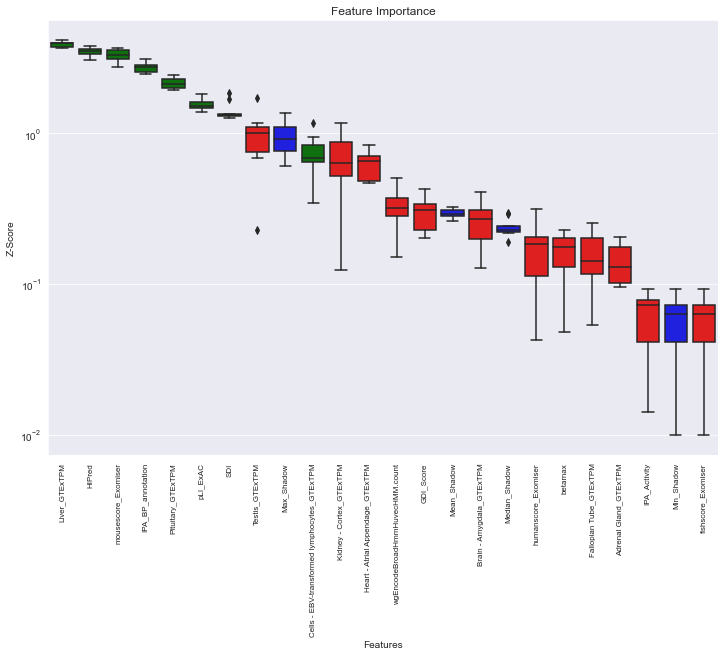

In [16]:
import seaborn as sns
sns.set_style("darkgrid")
sns.mpl.rcParams["figure.figsize"] = (15.0, 9.0)
Feature_Selector.plot(which_features="all")
#plt.savefig('BorutaShap_FS.png', format='png', dpi=300, bbox_inches = "tight")